# Ataque a una Convolutional Neuronal Network (CNN)

Lo primero que haremos será validar que el modelo funciona

In [0]:
#Import Libraries
import tensorflow as tf
import keras   #Api que funciona encima de TensorFlow

import matplotlib.pyplot as plt
import numpy as np

In [109]:
#Comprobamos poder utilizar la gpu para procesar
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#Keras nos ofrece el modelo pre-entrenado de Inception_V3
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [0]:
#Cargamos el modelo dentro de una variable
iv3 = InceptionV3()

Ahora lo que vamos a ver, sólo con fin ilustrativo, es la cantidad de capas que tiene el modelo y la cantidad de parámetros que la componen:
Entre más cantidad de parámetros tengamos mayor cantidad de datos serán necesarios para el proceso de optimización y reajuste de ésto parámetros

In [112]:
print(iv3.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, None, None, 3 96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, None, None, 3 0           batch_normalization_377[0][0]    
__________________________________________________________________________________________________
conv2d_378

Vamos a importar imágenes para probar nuestro modelo:

In [0]:
from keras.preprocessing import image  #Cargar imágenes para testear nuestro modelo.  

In [114]:
#Codigo de Colab para poder subir archivos
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving angry_puppy.jpg to angry_puppy (6).jpg
User uploaded file "angry_puppy.jpg" with length 125117 bytes


In [115]:
uploaded

{'angry_puppy.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xfe\x00;CREATOR: gd-jpeg v1.0 (using IJG JPEG v62), quality = 90\n\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc2\x00\x11\x08\x04\x00\x03\x8d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\xff\xc4\x00\x17\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xe5\xdd\xce{\xab\xa2*\x14A\x12\xa5\xaa**\x8a\xca\xb8`\xdd\xc4\xaa\xba*],\xba\xb2Id\xbb\x884bU\x15-K\xa2\xaa\xe07VP\x95\xa5Q.\xa0\xadc\xd6\x95\xd8Al\x81\xd1Z3\xab3)\xa0\x8d\xab\x90;\x95R

In [116]:
uploaded = files.upload()

x = image.load_img("angry_puppy.jpg")

print(x)

Saving angry_puppy.jpg to angry_puppy (7).jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=909x1024 at 0x7FEE2F219208>


<function matplotlib.pyplot.show>

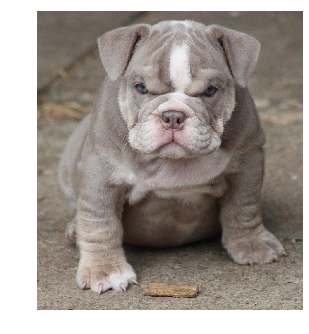

In [117]:
plt.axis("off")
plt.imshow(x)
plt.show

Lo que necesitamos es trabajar con datos numéricos por lo que vamos a poner éste fichero de tipo imagen representado por un matriz bidimensional o un tensor (matriz multidimensional):


In [118]:
#Creamos una matriz de valores en lugar de una imagen
x = image.img_to_array(image.load_img("angry_puppy.jpg"))

print(x.shape)
#Es una imagen con(altura, ancho, 3 canales de color(RGB))


(1024, 909, 3)


Para reentrenar el modelo **Inception V3** es necesario que la matriz tenga entre sus requisitos:
1. tamaño de la imagen sea una proporción de 299x299 px
- Cambiar el rango de 0,255 a -1,1
- Pasar de 3 a 4 dimensiones el tensor, en la primera dimensión agregamos el tamaño del lote (batch size)

In [119]:
1# Vamos a redimensionar la imagen:
x = image.img_to_array(image.load_img("angry_puppy.jpg", target_size=(299,299)))

print(x.shape)

(299, 299, 3)


In [120]:
2#Cambio de rango de 0,255 => -1,1
x /= 255
x -= 0.5   #centrando los valores
x *= 2

print(x)

[[[-0.20784312 -0.27058822 -0.372549  ]
  [-0.16862744 -0.23137254 -0.3333333 ]
  [-0.16862744 -0.23137254 -0.31764704]
  ...
  [-0.21568626 -0.27843136 -0.36470586]
  [-0.21568626 -0.27843136 -0.36470586]
  [-0.21568626 -0.29411763 -0.372549  ]]

 [[-0.15294117 -0.21568626 -0.31764704]
  [-0.1607843  -0.2235294  -0.32549018]
  [-0.14509803 -0.20784312 -0.29411763]
  ...
  [-0.26274508 -0.32549018 -0.41176468]
  [-0.20784312 -0.27058822 -0.35686272]
  [-0.23137254 -0.3098039  -0.38823527]]

 [[-0.15294117 -0.21568626 -0.31764704]
  [-0.14509803 -0.20784312 -0.3098039 ]
  [-0.1372549  -0.19999999 -0.2862745 ]
  ...
  [-0.21568626 -0.27843136 -0.36470586]
  [-0.27058822 -0.3333333  -0.41960782]
  [-0.24705881 -0.32549018 -0.40392154]]

 ...

 [[ 0.10588241  0.04313731 -0.04313725]
  [ 0.1686275   0.10588241  0.0196079 ]
  [ 0.05098045 -0.01176471 -0.09803921]
  ...
  [ 0.4039216   0.35686278  0.24705887]
  [ 0.01176476 -0.03529412 -0.12941176]
  [ 0.04313731 -0.02745098 -0.09803921]]

 [

In [121]:
#Pasar de 3 a cuatro dimensiones. La primera dimensión es el bactch Size es lote de imagenes que ingresaremos
x = x.reshape([1, x.shape[0], x.shape[1], x.shape[2]])

print(x.shape)

(1, 299, 299, 3)


Una vez lista la variable X como la necesitamos la ingresamos al modelo de Inception V3


In [0]:
y = iv3.predict(x)

In [123]:
#El tamaño de la variable "y" es de 1000 por el hecho que el modelo puede clasificar entre mil categorías
y.shape

(1, 1000)

Keras tiene una funcionalidad llamada `decode_predictions` que nos mapea entre todos los resultados y nos trae, en orden, las clases con probabilidades más altas y con su respectivo nombre:

#                                   FUNCIONA!!!

In [124]:
decode_predictions(y)
#Efectivamente un perro (realmente un perrito enojado)

[[('n02108915', 'French_bulldog', 0.511792),
  ('n02108422', 'bull_mastiff', 0.131935),
  ('n02108089', 'boxer', 0.04140407),
  ('n02093428', 'American_Staffordshire_terrier', 0.016959596),
  ('n02096585', 'Boston_bull', 0.0059203077)]]

# Segundo Paso: Ataque Adversario


Ahora que vemos que el modelo funciona correctamente lo que haremos será **ROMPERLO**.<br></br> 
Un Ataque Adversario será ingresar imágenes modificadas al modelo que le genere confusión y arroje un resultado diferente. Estas modificaciones deben ser impercetibles al ojo humano.<br></br>

Lo explico mejor en el [README](https://github.com/corozb/Ataque_Adversario_a_una_CNN/blob/master/README.md) de este repositorio.

In [0]:
#Vamos a trabajar sobre la capa de entrada de datos y la capa de salida
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output #Funciona con una función Softmax al final

target_class = 951 #Que identifique un limón con la imagen del perro

Construimos una función de coste que nos maximice el ERROR, es decir que maximice la capa de salida con la clase objetivo (951 = leemon)

In [0]:
loss = out_layer[0, target_class]

Cuando se quiere entrenar una red neuronal lo que necesitamos es encontrar el **gradiente** entre tu error y los parámetros eso te va a decir que valores tienes que utilizar para poco a poco ir minimizando ese error. En este caso el gradiente no lo vamos a usar sobre los parámetros sino sobre la variable de entrada definida (input_layer) que son los pixeles de la imagen

In [0]:
grad =K.gradients(loss, inp_layer)[0] #El coste con respecto al tensor de entrada

Nuestra variable "grad" hace referencia al proceso de calcular el **gradiente entre el error y la variable 
de entrada**. <br></br>
Con lo cual ya tendríamos un tensor que nos dirá en **que proporción tendremos que variar los píxeles de nuestra imagen** para que poco a poco la función de coste se **vaya optimizando**.<br></br>
Una función Keras tiene la particularidad que le damos las variables de entrada y cuales son los resultados que
queremos como salida y automáticamente crea una función que nos dará el grafo necesario. <br></br>
Es necesario aclararle al modelo cuando son datos de entrenamiento y cuando datos de testeo, se usa **K.learning_phase()**

In [128]:
#Creamos una función que se ejecutará iterativa para que haga el proceso de optimización del gradiente
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])

adv = np.copy(x) #hace una copia de la variable x antes de ser modificada
                               
cost = 0.0

#Igualmente al maximizar el error, queremos minimizar la diferencia entre la imagen original y la perturbada
pert = 0.01
max_pert = x + 0.01
min_pert = x - 0.01

                                
while cost < 0.95:
    gr, cost = optimize_gradient([adv, 0]) #ponemos dos variables porque fue lo que definimos como resultado
                                           # [grad, loss] 
    adv += gr
    
    #Ponemos lo límites de la perturbación dentro de la iteración
    adv = np.clip(adv, min_pert, max_pert)
    adv = np.clip(adv, -1, 1) # ponemos limites a los valores de las intensidades
    
    print('Target Cost:', cost)
    

hacked = np.copy(adv)

Target Cost: 0.00015683161
Target Cost: 0.00015823012
Target Cost: 0.00015963818
Target Cost: 0.00016105249
Target Cost: 0.00016251593
Target Cost: 0.00016400419
Target Cost: 0.00016552872
Target Cost: 0.00016707536
Target Cost: 0.0001686407
Target Cost: 0.0001702102
Target Cost: 0.00017180556
Target Cost: 0.00017340813
Target Cost: 0.00017501149
Target Cost: 0.00017664226
Target Cost: 0.00017830798
Target Cost: 0.00017997494
Target Cost: 0.00018164283
Target Cost: 0.00018333214
Target Cost: 0.00018503366
Target Cost: 0.00018674786
Target Cost: 0.00018847156
Target Cost: 0.00019018711
Target Cost: 0.0001919182
Target Cost: 0.00019368168
Target Cost: 0.00019546774
Target Cost: 0.00019727403
Target Cost: 0.00019904955
Target Cost: 0.00020081578
Target Cost: 0.0002025974
Target Cost: 0.00020438497
Target Cost: 0.00020616074
Target Cost: 0.00020795334
Target Cost: 0.00020977737
Target Cost: 0.00021163984
Target Cost: 0.00021351506
Target Cost: 0.0002153991
Target Cost: 0.00021729011
Target

Ahora lo que hacemos es revertir el proceso para visualizar la imagen

In [0]:
adv /=2
adv += 0.5
adv *= 255

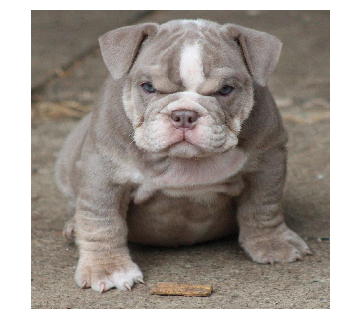

In [130]:
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(adv[0].astype(np.uint8))  #Convertinos valores en enteros ya que eran flotantes
plt.show()

In [131]:
adv[0].shape

(299, 299, 3)

In [0]:
#Ahora guardamos la imagen perturbada
from PIL import Image


im = Image.fromarray(adv[0].astype(np.uint8)) 
im.save("modified.png") #lo guardamos en png ya que si lo guardamos en jpg la calidad de la imagen baja y la intensidad de los pixeles igual 
                            #varía
files.download("modified.png") 

Ahora validamos que el Ataque Adversariio fue realizado. Eso lo comprobamos cargando la imagen que hemos perturbado y nos debe arrojar una probabilidad mayor en la clase **Lemon**


In [135]:
#Codigo Colaboratory para cargar archivo
uploaded = files.upload()

x = image.load_img("modified.png")

Saving modified.png to modified (2).png


In [0]:
1. #Vamos a redimensionar la imagen:
x = image.img_to_array(image.load_img("modified.png", target_size=(299,299)))

x /= 255
x -= 0.5   
x *= 2

x = x.reshape([1, x.shape[0], x.shape[1], x.shape[2]])

y = iv3.predict(x)

In [140]:
decode_predictions(y)

[[('n07749582', 'lemon', 0.99480325),
  ('n07747607', 'orange', 0.0022729104),
  ('n04409515', 'tennis_ball', 0.00032883763),
  ('n07742313', 'Granny_Smith', 0.00023593171),
  ('n02797295', 'barrow', 0.00016644539)]]

# LO HEMOS HECHO!!
El modelo ha sido confundido y muestra un limon cuando es una imagen de un cachorro


`Este ejemplo fue creado gracias al canal` [Dot CSV](https://www.youtube.com/channel/UCy5znSnfMsDwaLlROnZ7Qbg/featured)`